In [1]:
import os
import datetime
import requests
import zipfile
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
%matplotlib inline

# 0. Get Data 

In [3]:
sorted(list(filter(lambda f: not f.startswith("."), os.listdir("."))))

['README.md',
 'census_data.csv',
 'data_science_answers.ipynb',
 'data_science_raw.ipynb',
 'duplicates.csv',
 'env',
 'pandas_basics.ipynb',
 'pandas_basics_addntl.ipynb',
 'pandas_basics_answers.ipynb',
 'python_basics.ipynb',
 'python_basics_addntl.ipynb',
 'python_basics_answers.ipynb',
 'quantquote_daily_sp500_83986',
 'requirements.txt',
 'time_series_analysis.ipynb',
 'time_series_analysis_answers.ipynb',
 'y_test.csv']

In [4]:
def get_data(data_url):
    with requests.get(data_url) as r:

        with zipfile.ZipFile(io.BytesIO(r.content)) as z:
            z.extractall()

In [5]:
data_url = "http://quantquote.com/files/quantquote_daily_sp500_83986.zip"

In [6]:
get_data(data_url=data_url)

In [7]:
data_dir = os.path.join("quantquote_daily_sp500_83986", "daily")

In [8]:
len(os.listdir(data_dir))

500

### Scope out data directory

In [9]:
stock_csv_names = sorted(os.listdir(data_dir))

In [10]:
len(stock_csv_names)

500

In [11]:
stock_csv_names[:5]

['table_a.csv',
 'table_aa.csv',
 'table_aapl.csv',
 'table_abbv.csv',
 'table_abc.csv']

In [19]:
cols = ['date', 'time', 'open', 'high', 'low_price', 'close', 'volume']

### Look at sample of data

In [13]:
a_df = pd.read_csv(os.path.join(data_dir, stock_csv_names[0]),
                   names=cols)

In [14]:
a_df.shape

(3452, 7)

In [15]:
a_df.head()

,date,time,open,high,low_price,close,volume
0,19991118,0,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1,19991119,0,39.8329,39.8885,36.9293,37.6251,1.139020e+07
2,19991122,0,38.3208,40.0091,37.1613,39.9442,4.654716e+06
3,19991123,0,39.4247,40.4729,37.3375,37.5138,4.268903e+06
4,19991124,0,37.2262,38.9052,37.1056,38.0889,3.602367e+06


In [16]:
a_df.dtypes

date           int64
time           int64
open         float64
high         float64
low_price    float64
close        float64
volume       float64
dtype: object

We see that most of the typing here looks good (no `object` / `string` representations of numeric data) but we do see that `date` is coming in as an `int` rather than a `datetime`. Why is this important? Because, as we will see later, we want our `date` column's values to look, act, and feel like _dates_, as opposed to _integers_.

Also, we see that the `time` column has a value of `0` in the top five rows, and we know that this is _daily_ data - is `time` relevant?

Before we get in to handling these issues, let's continue with our basic data quality checks.

In [17]:
a_df.isnull().sum()

date         0
time         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [18]:
a_df.duplicated().sum()

0

Great! No missing data, and no duplicate data.

In [20]:
a_df.date.astype(str).head()

0    19991118
1    19991119
2    19991122
3    19991123
4    19991124
Name: date, dtype: object

The `pandas` library provides a function, `to_datetime`, that will often work to pretty automatically convert a column into `datetime` values. Once in a while, these conversions will require some manual intervention. Let's try this function on our `date` column:

In [21]:
a_df.date = pd.to_datetime(a_df.date.astype(str), infer_datetime_format=True)

In [22]:
a_df.date.head()

0   1999-11-18
1   1999-11-19
2   1999-11-22
3   1999-11-23
4   1999-11-24
Name: date, dtype: datetime64[ns]

Let's check that this is a _proper_ time-series data set, i.e. we're indexed on _time_, which in this case will mean that we have one date for every row:

In [23]:
a_df.date.nunique() / len(a_df)

1.0

Great - we can now set this as our index, which will make many analytical techniques (plotting and joining, for example) easier:

In [24]:
a_df = a_df.set_index("date")

And, `time`:

In [25]:
a_df.time.nunique()

1

In [26]:
a_df = a_df.drop("time", axis=1)

### Problem

Get an _iterable_ of `DataFrames`, one for each stock in our dataset, with the wrangling we did above included.

In [27]:
def get_csv_path(csv_name, stock_csv_folder=data_dir):
    return os.path.join(stock_csv_folder, csv_name)

In [28]:
def get_df(csv_name, cols=cols):
    df = pd.read_csv(get_csv_path(csv_name),
                     names=cols,
                     usecols=list(filter(lambda c: c!= "time", cols)))
    
    df.date = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)

    return df.set_index("date", drop=False)

In [29]:
dfs_iter = (
    get_df(csv_name
    ) for csv_name in stock_csv_names
)

In [30]:
dfs_list = list(dfs_iter)

In [31]:
len(dfs_list)

500

# 1. Analysis: `AAPL`

### Initial look

In [32]:
aapl_df = get_df("table_aapl.csv")

In [33]:
aapl_df.shape

(3926, 6)

**Note**: we have more rows for `aapl` data than we do for `a`.

In [34]:
pd.Series(aapl_df.index).quantile([0, 1])

0.0   1998-01-02
1.0   2013-08-09
Name: date, dtype: datetime64[ns]

In [35]:
pd.Series(a_df.index).quantile([0, 1])

0.0   1999-11-18
1.0   2013-08-09
Name: date, dtype: datetime64[ns]

As expected, both `DataFrames` have same end date, but `aapl`'s data starts earlier.

In [36]:
aapl_df.isnull().sum()

date         0
open         0
high         0
low_price    0
close        0
volume       0
dtype: int64

In [37]:
aapl_df.duplicated().sum()

0

Let's take a look at the `aapl` data:

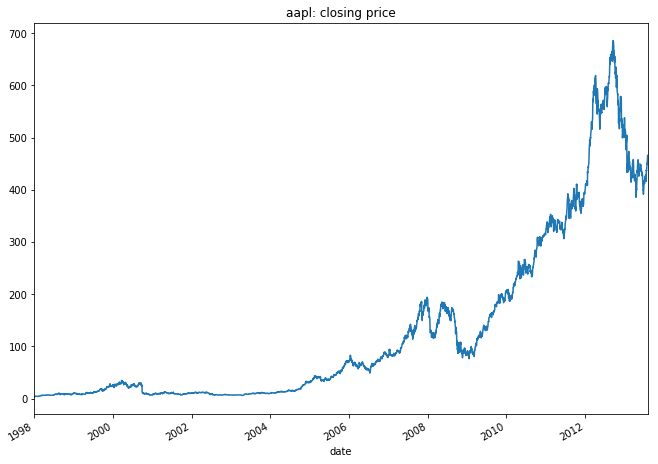

In [38]:
ax = aapl_df.close.plot(figsize=(11, 8))
t = ax.set_title("aapl: closing price")

A couple of observations on the above graph:
- the stock's price has increased over time
- there is a good bit of variability in between the start and end points
- it would have been nice to buy `AAPL` back in the 90s!

How can we get a more insight into how this stock's price moves?

### Returns

In [43]:
aapl_df["return_gross"] = aapl_df.close.divide(aapl_df.close.shift(1))

In [44]:
aapl_df["return_simple"] = aapl_df.return_gross - 1

In [45]:
aapl_df.return_simple.describe()

count    3925.000000
mean        0.001672
std         0.029774
min        -0.518150
25%        -0.013670
50%         0.000859
75%         0.016312
max         0.183749
Name: return_simple, dtype: float64

Let's view our returns, _distirbutionally_:

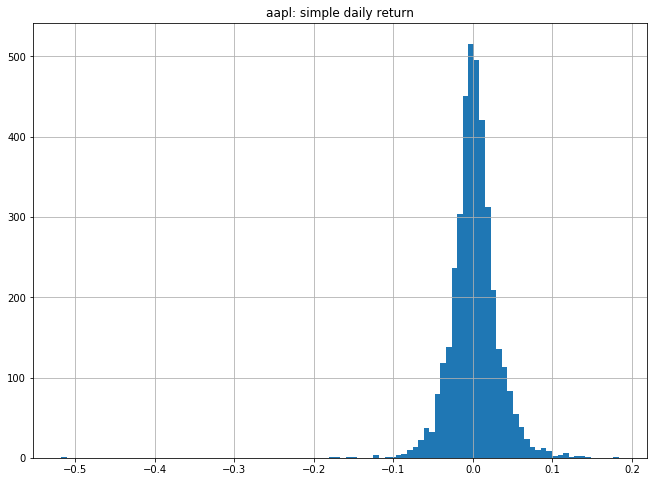

In [46]:
ax = aapl_df.return_simple.hist(figsize=(11, 8), bins=100)

t = ax.set_title("aapl: simple daily return")

Note the long tail stretching out to the left - this data is _negatively skewed_. Let's look more closely into that:

In [47]:
aapl_df.return_simple.quantile([0, .01, .05, .1, .25])

0.00   -0.518150
0.01   -0.070870
0.05   -0.042636
0.10   -0.030308
0.25   -0.013670
Name: return_simple, dtype: float64

In [48]:
(aapl_df.return_simple < -.1).sum()

10

In [49]:
aapl_df[aapl_df.return_simple < -.1]

,date,open,high,low_price,close,volume,return_gross,return_simple
date,,,,,,,,
1999-01-14,1999-01-14,11.06280,11.18440,9.98318,10.07560,5.813583e+07,0.892333,-0.107667
1999-09-21,1999-09-21,17.79520,17.80980,16.77650,16.81050,1.138997e+08,0.875187,-0.124813
2000-09-29,2000-09-29,13.64490,14.10200,12.34160,12.52160,2.339738e+08,0.481850,-0.518150
2000-12-06,2000-12-06,7.11421,7.29413,6.80785,6.99264,4.577349e+07,0.845883,-0.154117
2001-07-18,2001-07-18,10.62510,10.69810,9.92974,10.10480,3.854362e+07,0.829214,-0.170786
2002-06-19,2002-06-19,8.44660,8.55844,8.20832,8.33476,5.893970e+07,0.850621,-0.149379
2002-07-17,2002-07-17,7.84362,7.87766,7.38652,7.62479,4.142656e+07,0.878923,-0.121077
2008-01-23,2008-01-23,132.46100,136.15700,122.67700,135.03800,1.181346e+08,0.880185,-0.119815
2008-09-29,2008-09-29,116.41400,116.41400,97.82880,103.12900,9.250666e+07,0.823352,-0.176648


Now, we can also view our returns _chronologically_:

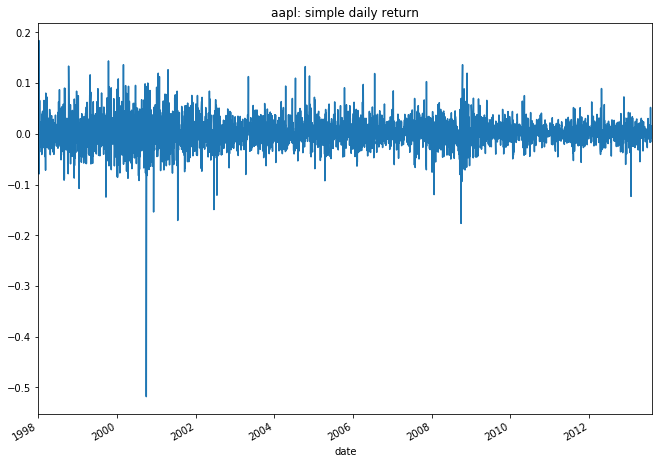

In [50]:
ax = aapl_df.return_simple.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return")

In [61]:
res = sm.tsa.seasonal_decompose(aapl_df.return_simple.dropna(), freq=252)

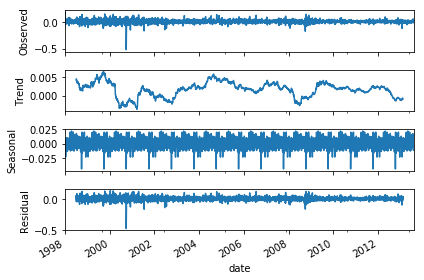

In [62]:
resplot = res.plot()

There's _a lot_ of fluctuation going on here - can we reduce this?

In [51]:
aapl_df["return_simple_rolling_21_mean"] = aapl_df.return_simple.rolling(21).mean()

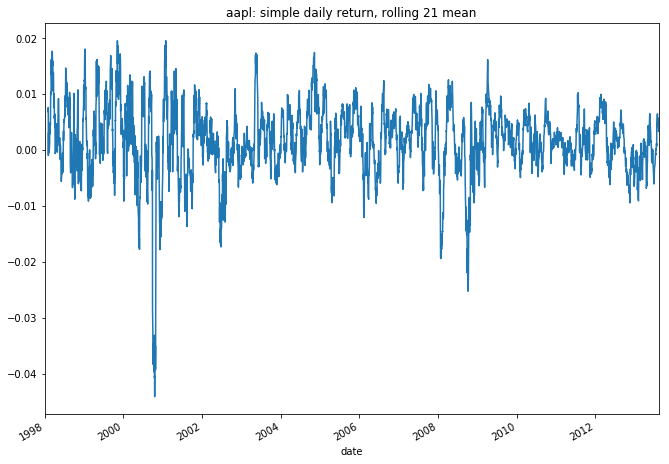

In [52]:
ax = aapl_df.return_simple_rolling_21_mean.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 21 mean")

In [73]:
def set_and_plot_rolling_mean(window):
    col_name = f"return_simple_rolling_{window}_mean"
    aapl_df[col_name] = aapl_df.return_simple.rolling(window).mean()
    
    ax = aapl_df[col_name].plot(figsize=(11, 8))
    t = ax.set_title(f"aapl: simple daily return, rolling {window} day mean")

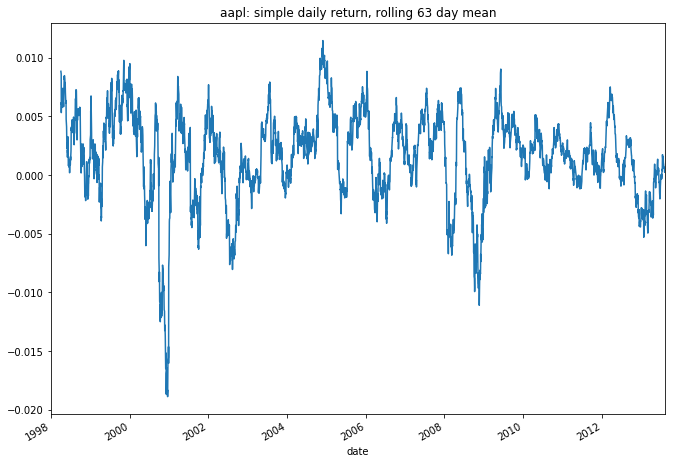

In [74]:
set_and_plot_rolling_mean(63)

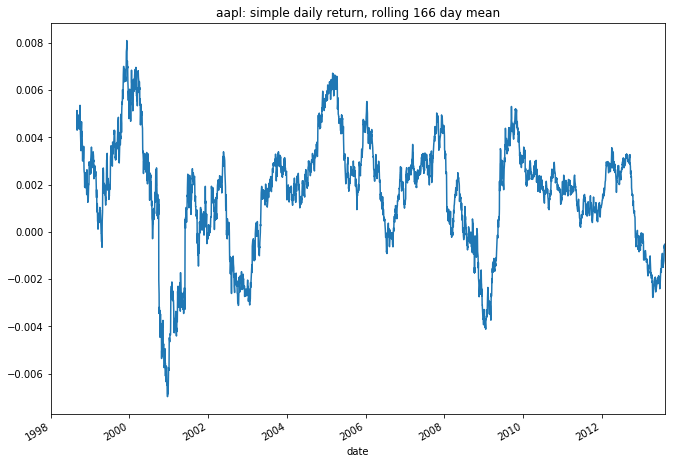

In [75]:
set_and_plot_rolling_mean(166)

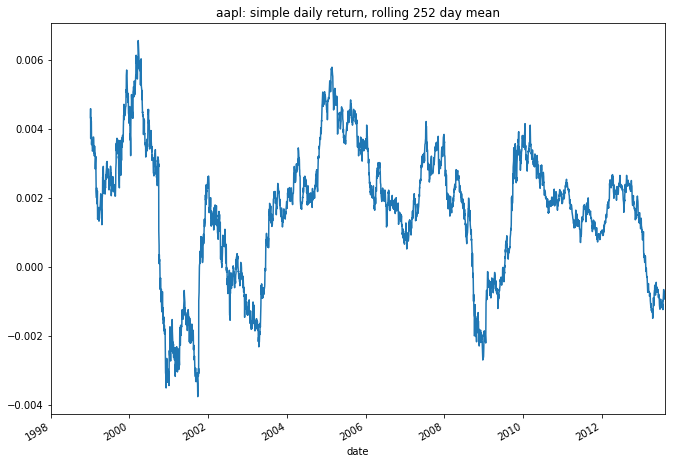

In [76]:
set_and_plot_rolling_mean(252)

Interesting - our _daily returns_ look to be decreasing over time.

How about volatility?

In [85]:
aapl_df["return_simple_63_std"] = aapl_df.return_simple.rolling(63).std()

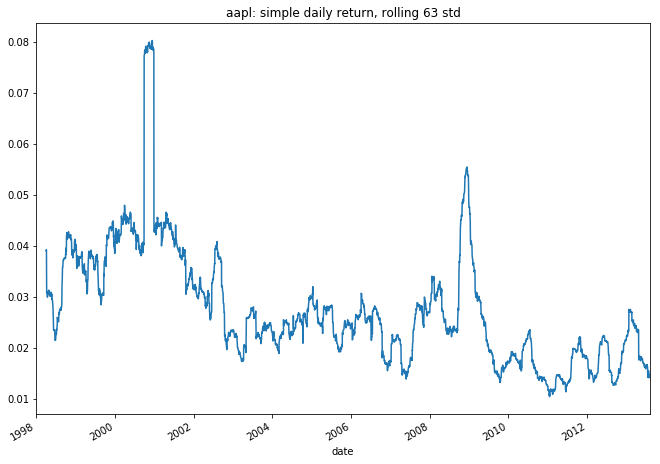

In [86]:
ax = aapl_df.return_simple_63_std.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 63 std")

In [87]:
[c for c in aapl_df.columns if "63" in c]

['return_simple_rolling_63_mean', 'return_simple_63_std']

In [90]:
aapl_quarterly = aapl_df[[c for c in aapl_df.columns if "63" in c]
                        ].dropna()

In [91]:
aapl_quarterly = aapl_quarterly / aapl_quarterly.iloc[0]

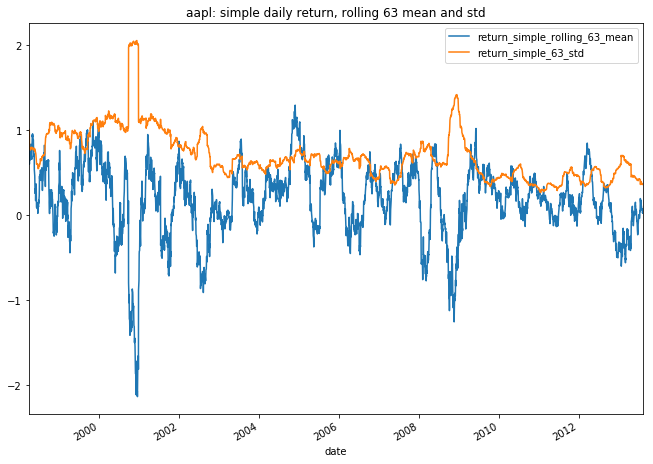

In [92]:
ax = aapl_quarterly.plot(figsize=(11, 8))
t = ax.set_title("aapl: simple daily return, rolling 63 mean and std")

In [93]:
res = sm.tsa.seasonal_decompose(aapl_df.return_simple_63_std.dropna(), freq=252)

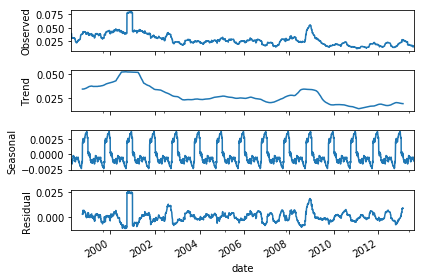

In [94]:
resplot = res.plot()

### Problem

Perform a similar analysis to what we did with `aapl.simple_returns` but do this using _volume-weighted_ returns. Describe your findings - do the results look similar?

### Average daily returns, by month

Does `AAPL` post better daily performance in certain months?

In [100]:
aapl_df["month"] = aapl_df.date.apply(lambda d: d.month)

In [101]:
daily_by_month = aapl_df[["month", "return_simple"]
                         ].groupby("month"
                         ).agg([np.mean, np.std])

In [102]:
daily_by_month

return_simple          
               mean       std
month                        
1          0.002190  0.034613
2          0.001037  0.025793
3          0.003630  0.027720
4          0.002755  0.030354
5         -0.000095  0.025757
6          0.000647  0.024897
7          0.003089  0.030554
8          0.001921  0.023400
9         -0.000956  0.042424
10         0.003242  0.033829
11         0.001369  0.028624
12         0.000834  0.025551

In [103]:
daily_by_month.columns = daily_by_month.columns.droplevel()

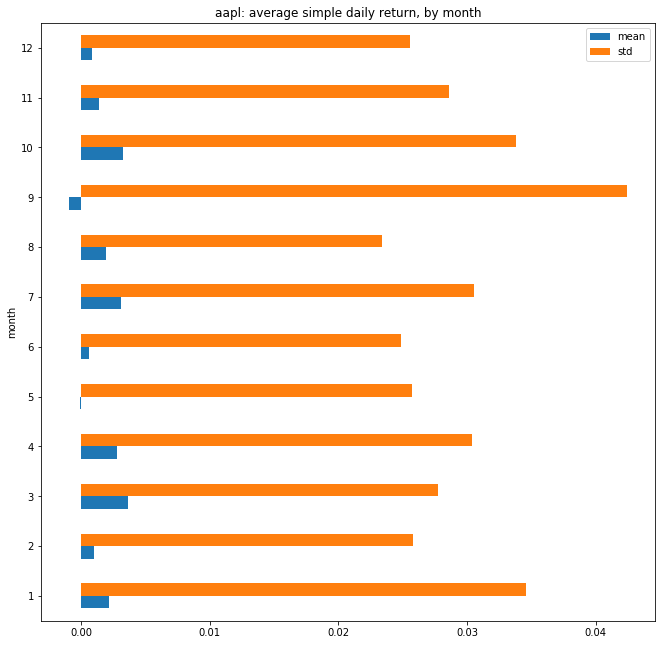

In [104]:
ax = daily_by_month.plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple daily return, by month")

So, we see that, on average, `AAPL` has seen negative daily returns (with higher-than-average volatility) in September - earnings?

In [122]:
monthlies = aapl_df.return_gross.resample("m").agg([np.cumprod]) - 1

In [123]:
monthlies = monthlies.reset_index()

In [124]:
monthlies["month"] = monthlies.date.apply(lambda d: d.month)

In [125]:
monthlies = monthlies[["month", "cumprod"]
                      ].groupby("month"
                      ).agg([np.mean, np.std])

In [126]:
monthlies.columns = monthlies.columns.droplevel()

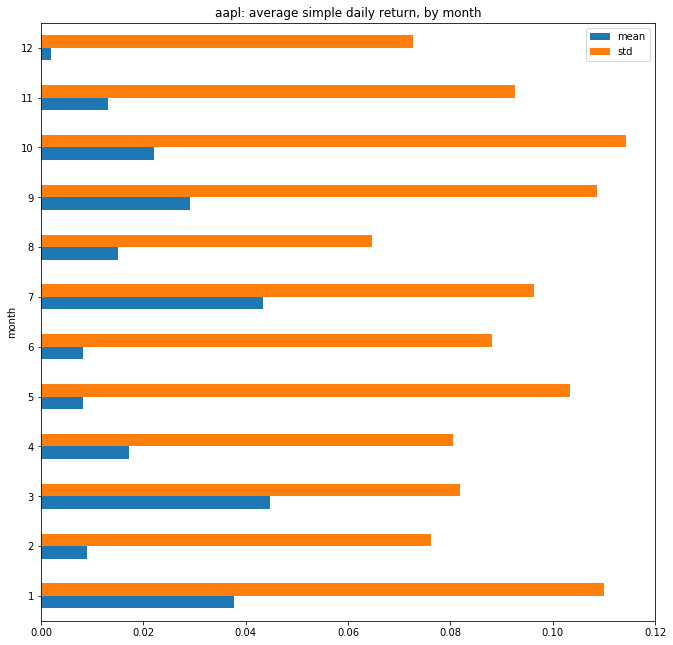

In [127]:
ax = monthlies.plot.barh(figsize=(11, 11))

t = ax.set_title("aapl: average simple daily return, by month")

### Problem

Perform a similar analysis to above, but instead of calculating the average (and volatility around) _daily_ returns, broken out by month, get the average (and volatility around) _monthly_ returns.

### Digging deeper into September earnings

In [63]:
aapl_df["year"] = aapl_df.date.apply(lambda d: d.year)

In [64]:
aapl_sept = aapl_df[aapl_df.month == 9]

In [65]:
aapl_sept.shape

(302, 13)

In [81]:
sept_returns_by_year = aapl_sept[["year", "return_gross"]].groupby("year").apply(np.cumproduct)

In [82]:
sept_returns_by_year.sort_values("return_gross", ascending=False).iloc[:5]

,year,return_gross
date,,
1998-09-29,1.027803e+66,1.266431
1998-09-28,5.144157e+62,1.252324
1998-09-25,2.574653e+59,1.242385
1998-09-24,1.288615e+56,1.234369
1998-09-08,3.184032e+16,1.224431


In [83]:
sept_returns_by_year.sort_values("return_gross").iloc[:5]

,year,return_gross
date,,
2000-09-29,1.048576e+66,0.422547
2008-09-29,1.135728e+66,0.625532
2008-09-30,2.280541e+69,0.669131
2008-09-23,6.985851e+52,0.749172
2008-09-24,1.402759e+56,0.757142


### Problem

Perform a similar, September analysis, on `MSFT`. Next, plot both `AAPL` and `MSFT` results on the same plot. 

Hint: you may find success through combining the results into a single `DataFrame` prior to plotting. You may also be able to make use of the `ax` we've been returning, through passing them into the next plot (the variable is aptly named...)

# Multi-Stock Analysis

### How can we combine all of our stocks into one `DataFrame`?

In [96]:
# all_stocks = dfs_list[0].join(dfs_list[1:])

In [89]:
def get_stock_name(csv_name):
    file_name = csv_name.split(".")[0]
    return file_name.split("_")[1]

In [90]:
dfs_list_indexed = [pd.concat({get_stock_name(csv_name): dfs_list[i]}, axis=1)
                    for i, csv_name in enumerate(stock_csv_names)]

In [91]:
all_stocks = dfs_list_indexed[0].join(dfs_list_indexed[1:])

In [92]:
all_stocks.iloc[:5, :8]

a                                                     \
                 date     open     high low_price    close        volume   
date                                                                       
1999-11-18 1999-11-18  42.2076  46.3820   37.4581  39.1928  4.398181e+07   
1999-11-19 1999-11-19  39.8329  39.8885   36.9293  37.6251  1.139020e+07   
1999-11-22 1999-11-22  38.3208  40.0091   37.1613  39.9442  4.654716e+06   
1999-11-23 1999-11-23  39.4247  40.4729   37.3375  37.5138  4.268903e+06   
1999-11-24 1999-11-24  37.2262  38.9052   37.1056  38.0889  3.602367e+06   

                   aa           
                 date     open  
date                            
1999-11-18 1999-11-18  24.5183  
1999-11-19 1999-11-19  24.5647  
1999-11-22 1999-11-22  24.6846  
1999-11-23 1999-11-23  25.0018  
1999-11-24 1999-11-24  25.0482

In [93]:
all_stocks["a"].head()

,date,open,high,low_price,close,volume
date,,,,,,
1999-11-18,1999-11-18,42.2076,46.3820,37.4581,39.1928,4.398181e+07
1999-11-19,1999-11-19,39.8329,39.8885,36.9293,37.6251,1.139020e+07
1999-11-22,1999-11-22,38.3208,40.0091,37.1613,39.9442,4.654716e+06
1999-11-23,1999-11-23,39.4247,40.4729,37.3375,37.5138,4.268903e+06
1999-11-24,1999-11-24,37.2262,38.9052,37.1056,38.0889,3.602367e+06


### `close`

In [94]:
all_stocks["a"]["close"].head()

date
1999-11-18    39.1928
1999-11-19    37.6251
1999-11-22    39.9442
1999-11-23    37.5138
1999-11-24    38.0889
Name: close, dtype: float64

In [95]:
tickers = all_stocks.columns.levels[0]

In [96]:
tickers[:5]

Index(['a', 'aa', 'aapl', 'abbv', 'abc'], dtype='object')

In [97]:
_all_close_list = [all_stocks[tick].close for tick in tickers]

In [98]:
_all_close_list[0].head()

date
1999-11-18    39.1928
1999-11-19    37.6251
1999-11-22    39.9442
1999-11-23    37.5138
1999-11-24    38.0889
Name: close, dtype: float64

In [99]:
_all_close_list = [srs.rename(tickers[i])
                  for i, srs in enumerate(_all_close_list)]

In [100]:
all_stocks_close = _all_close_list[0].to_frame().join(_all_close_list[1:])

In [101]:
all_stocks_close.iloc[:5, :8]

,a,aa,aapl,abbv,abc,abt,ace,acn
date,,,,,,,,
1999-11-18,39.1928,24.2514,21.7924,NaN,3.09830,11.9023,14.3008,NaN
1999-11-19,37.6251,24.6846,22.4756,NaN,3.05589,11.8612,13.9294,NaN
1999-11-22,39.9442,25.0250,22.0185,NaN,2.95767,12.2375,14.0259,NaN
1999-11-23,37.5138,25.2185,22.6264,NaN,2.74784,12.0383,13.9294,NaN
1999-11-24,38.0889,24.9283,23.0373,NaN,2.74784,12.1964,13.3722,NaN


In [102]:
all_stocks_close = all_stocks_close / all_stocks_close.shift(1)

### Correlation

In [103]:
corrs = all_stocks_close.corr()

In [104]:
corrs.iloc[:5, :5]

,a,aa,aapl,abbv,abc
a,1.000000,0.383146,0.361200,0.164908,0.169508
aa,0.383146,1.000000,0.283109,0.067920,0.254100
aapl,0.361200,0.283109,1.000000,0.032483,0.142794
abbv,0.164908,0.067920,0.032483,1.000000,0.282846
abc,0.169508,0.254100,0.142794,0.282846,1.000000


In [109]:
corrs_modified = corrs.replace(1, np.nan)

In [110]:
corrs_modified.iloc[:5, :5]

,a,aa,aapl,abbv,abc
a,NaN,0.383146,0.361200,0.164908,0.169508
aa,0.383146,NaN,0.283109,0.067920,0.254100
aapl,0.361200,0.283109,NaN,0.032483,0.142794
abbv,0.164908,0.067920,0.032483,NaN,0.282846
abc,0.169508,0.254100,0.142794,0.282846,NaN


In [111]:
corrs_modified.max().sort_values(ascending=False)[:5]

eqr    0.884192
avb    0.884192
spg    0.883757
bxp    0.883757
vno    0.883234
dtype: float64

In [112]:
corrs_modified.min().sort_values(ascending=False)[:5]

wyn    0.178355
pfg    0.175845
dfs    0.175066
dd     0.168540
hst    0.159443
dtype: float64

### Problem

Create a _price index_ that provides insight into the daily tendencies of our 500 stocks. We are going to do this as follows: calculate, for each day, _the mean spread between open and closing prices across all 500 stocks_. 

Next, vizualize your results. Plot on the same axes a the _volatility of the open and closing price spreads_.

Additionally, find
- the 10 days with the highest average open-close spreads
- the 10 days with the highest volatility in their open-close spreads